In [ ]:
##############################
# Library Imports
##############################
import copy
import json
import itertools
import math
from datetime import datetime
from random import randint

# Frameworks
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns


# Plotly 
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio


# scikit-learn
from sklearn import metrics
from sklearn import set_config
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel, RFE
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer, make_column_selector, TransformedTargetRegressor, ColumnTransformer
from sklearn.inspection import permutation_importance
from category_encoders import TargetEncoder
from sklearn.naive_bayes import GaussianNB, CategoricalNB

# xgboost
import xgboost as xgb
from xgboost import XGBClassifier

##############################
# Runtime Settings
##############################
set_config(display="diagram")
import warnings
warnings.filterwarnings('ignore')

##############################
# Flow control + Constants
##############################
DEV_MODE = False
ENABLE_IQR_DATA_FILTERING = True
USE_TARGET_ENCODER_FOR_HIGH_CARDINALTY = True
MODEL1_ACTIVE = True
MODEL2_ACTIVE = True
MODEL3_ACTIVE = True
MODEL4_ACTIVE = False

IMAGE_DIR_SUFFIX = ''


# Constants
IMAGE_PREFIX = './analysis_images/prac_app_11_01.'
TARGET_FIELD = 'price'
ALPHA_START = 0.00001
ALPHA_END = 100
ALPHA_STEP = (ALPHA_END - ALPHA_START)/10
ALPHA_RANGE = np.arange(ALPHA_START, ALPHA_END, ALPHA_STEP)
IGNORE_FEATURES = ['VIN', 'id', 'model', 'paint_color']
CONFIG_NODE_KEY = 'config'
Q3_PERCENT_DEFAULT = 75
Q1_PERCENT_DEFAULT = 25

# https://www.maksimeren.com/post/screen-and-jupyter-a-way-to-run-long-notebooks-headless/
# cd ~/git/_jupyter_projects/berkeley/git/aimless/assignment_11_01
# jupyter nbconvert --to notebook --execute used_car_price_analysis.ipynb --output=used_car_price_analysis.out.ipynb --ExecutePreprocessor.timeout=-1

##############################
# Common global methods
##############################
def dataFrame2Image(inputDf, path, baseHeight=480, height_per_row=20, char_limit=30, height_padding=16.5, baseWidth=1200):
    total_height = 0 + baseHeight
    for x in range(inputDf.shape[0]):
        total_height += height_per_row
    for y in range(inputDf.shape[1]):
        if len(str(inputDf.iloc[x][y])) > char_limit:
            total_height += height_padding

    height = total_height
    width = baseWidth
    layout = {
        'height': height, 
        'width': width,
        'margin': {'r': 1, 'l': 1, 't': 1, 'b': 1}
    }
    
    fig = go.Figure(data=[
            go.Table(
                header=dict(values=list(inputDf.columns), fill_color='paleturquoise', align='left'),
                cells=dict(values=inputDf.transpose().values.tolist(), fill_color='lavender', align='left')
            )], layout=layout)
    fig.show()
    
    pio.write_image(fig, path, scale=1, width=width, height=total_height)

# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

<b>Business Understanding:</b> Determine which combination of numeric and categorical features and corresponding categorical values most contribute to driving price increase for used cars. Rank the features and values based on weight to give the used car dealers a simple way to prioritize used cars to display

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 126 to 119580
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            10000 non-null  int64  
 1   region        10000 non-null  object 
 2   price         10000 non-null  int64  
 3   year          10000 non-null  float64
 4   manufacturer  10000 non-null  object 
 5   model         10000 non-null  object 
 6   condition     10000 non-null  object 
 7   cylinders     10000 non-null  object 
 8   fuel          10000 non-null  object 
 9   odometer      10000 non-null  float64
 10  title_status  10000 non-null  object 
 11  transmission  10000 non-null  object 
 12  VIN           10000 non-null  object 
 13  drive         10000 non-null  object 
 14  size          10000 non-null  object 
 15  type          10000 non-null  object 
 16  paint_color   10000 non-null  object 
 17  state         10000 non-null  object 
dtypes: float64(2), int64(2), obj

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
126,7305672709,auburn,0,2018.0,chevrolet,express cargo van,like new,6 cylinders,gas,68472.0,clean,automatic,1GCWGAFP8J1309579,rwd,full-size,van,white,al
127,7305672266,auburn,0,2019.0,chevrolet,express cargo van,like new,6 cylinders,gas,69125.0,clean,automatic,1GCWGAFP4K1214373,rwd,full-size,van,white,al
128,7305672252,auburn,0,2018.0,chevrolet,express cargo van,like new,6 cylinders,gas,66555.0,clean,automatic,1GCWGAFPXJ1337903,rwd,full-size,van,white,al
215,7316482063,birmingham,4000,2002.0,toyota,echo,excellent,4 cylinders,gas,155000.0,clean,automatic,JTDBT123520243495,fwd,compact,sedan,blue,al
219,7316429417,birmingham,2500,1995.0,bmw,525i,fair,6 cylinders,gas,110661.0,clean,automatic,WBAHD6322SGK86772,rwd,mid-size,sedan,white,al


,id,price,year,odometer
count,1.000000e+04,10000.000000,10000.000000,1.000000e+04
mean,7.312079e+09,14995.557300,2011.233500,1.039360e+05
std,4.254589e+06,13594.054282,7.152587,6.378215e+04
min,7.301592e+09,0.000000,1928.000000,0.000000e+00
25%,7.309160e+09,5899.000000,2008.000000,6.052200e+04
50%,7.313524e+09,11390.000000,2013.000000,1.006540e+05
75%,7.315609e+09,20995.000000,2016.000000,1.389000e+05
max,7.316963e+09,150000.000000,2021.000000,2.319010e+06


array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'price'}>],
       [<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'odometer'}>]], dtype=object)

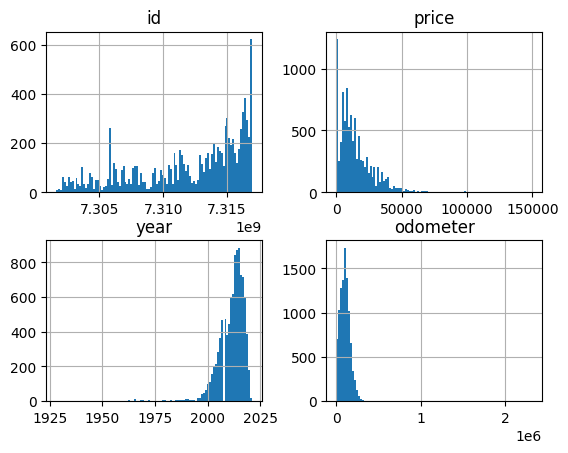

In [8]:
rawDf = pd.read_csv('./data/vehicles.csv')

# Reduce data set 
if DEV_MODE == True:
    rawDf  = rawDf.dropna()
    rawDf = rawDf.head(10000)

rawDf.info()
display(rawDf.dropna().head())
display(rawDf.describe())
rawDf.hist(bins=100)

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

Processing: toLowerCase
Processing: dropna
Processing: queryFilter
Processing: iqr
Processing: fillna
Processing: fillUsingMode
Processing: fillna


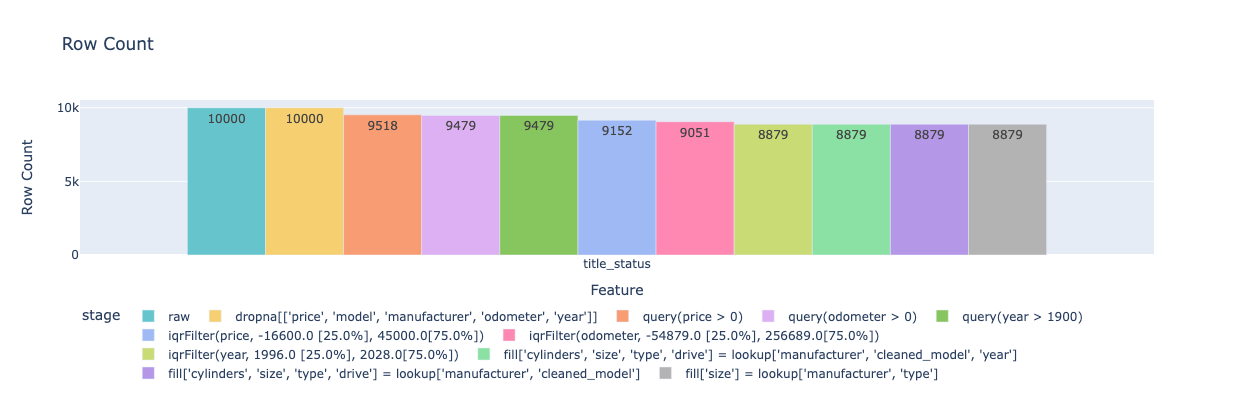

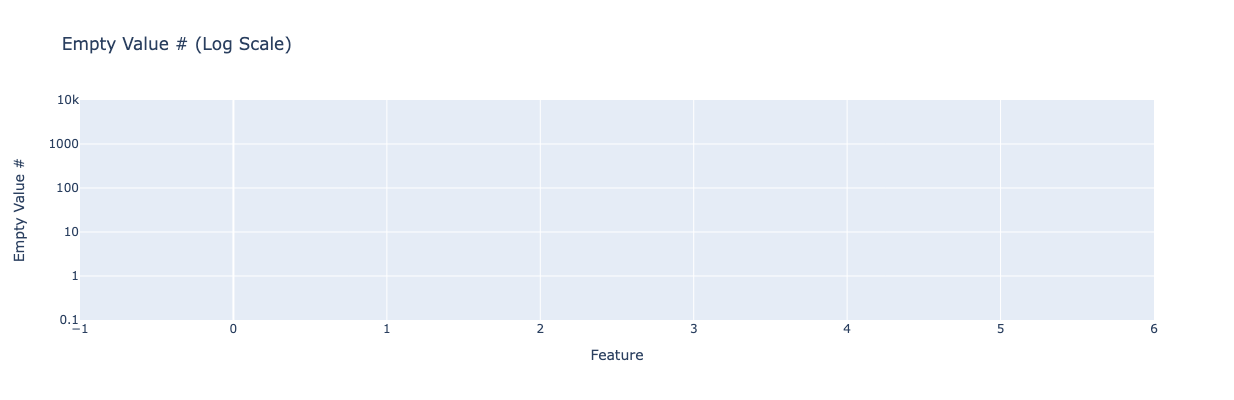

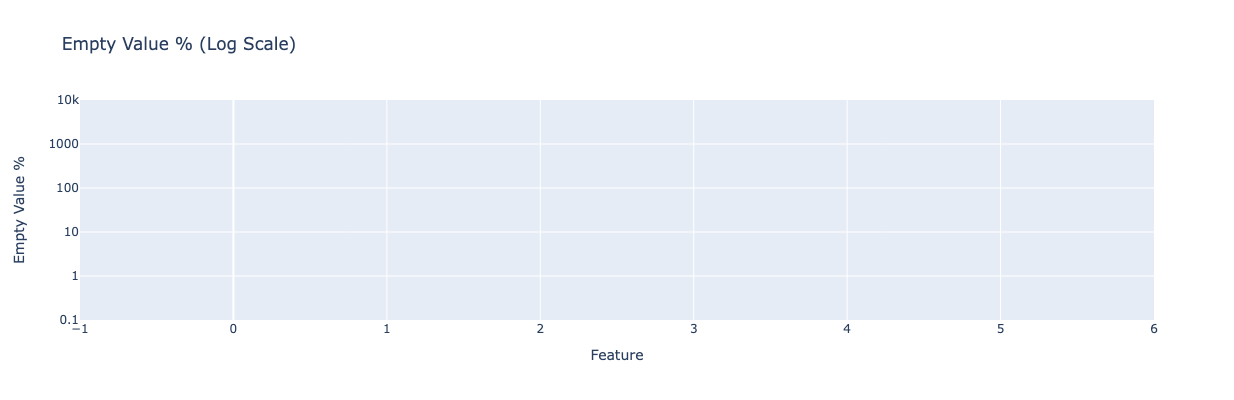

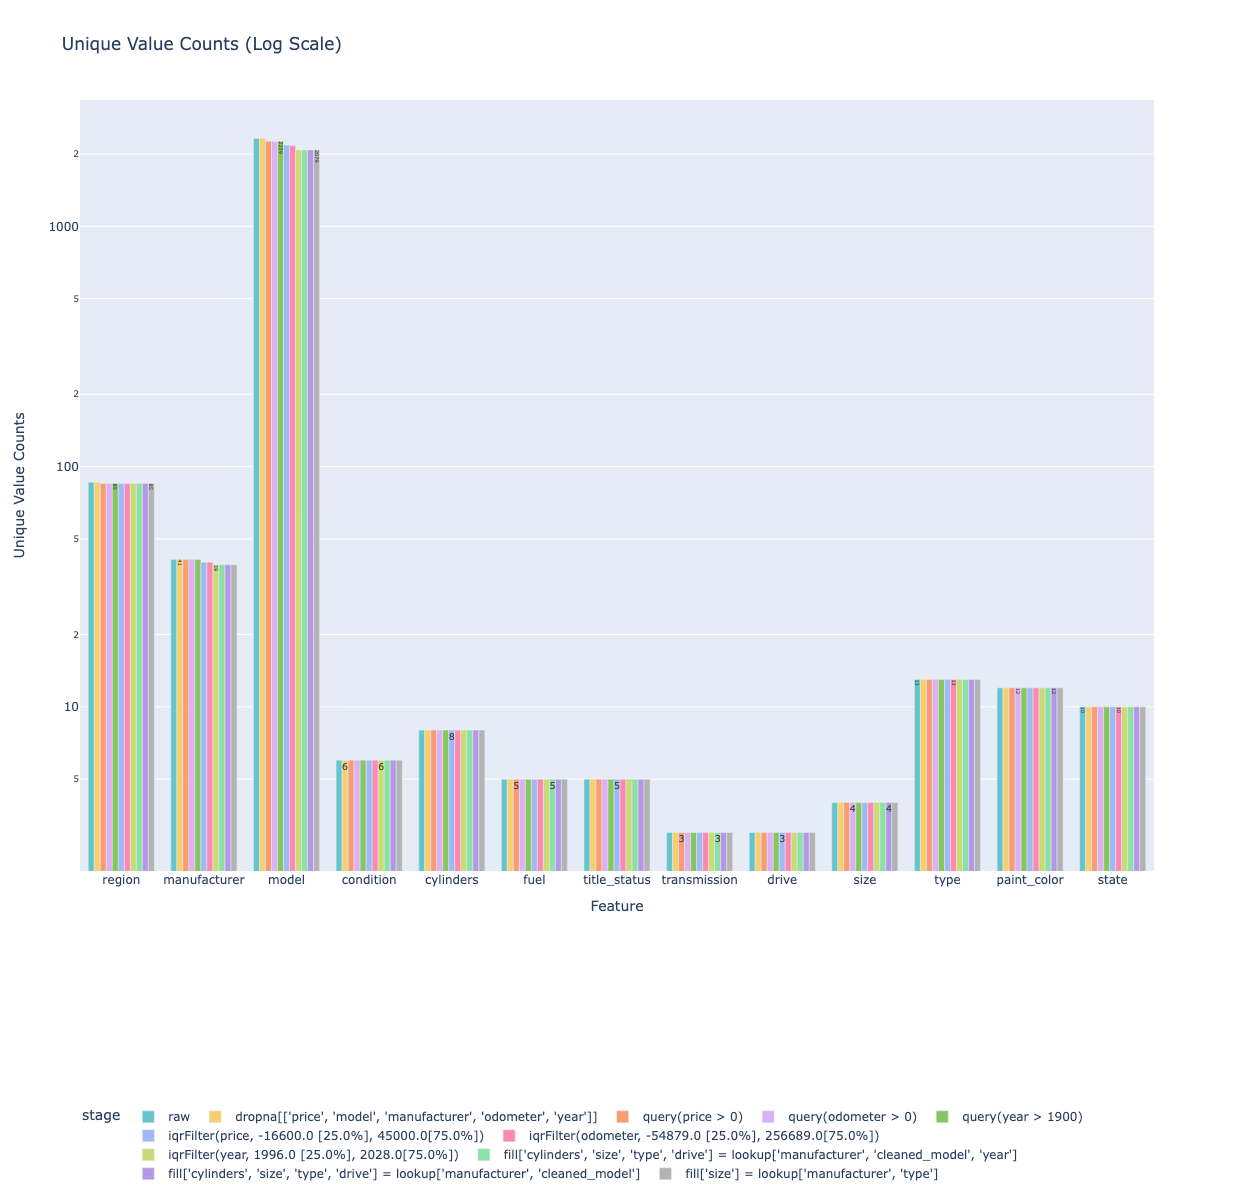

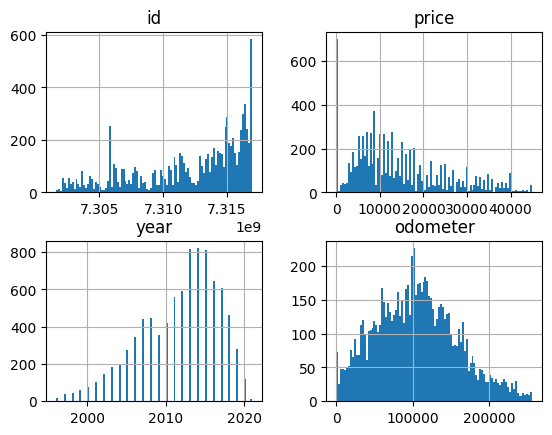

In [42]:
fixedCounter = {}
def displayStats(request, dataReportDf, restrictToStages = []):
    suffix = ''
    if(len(restrictToStages) > 0):
        suffix = '.' + '-'.join(restrictToStages) + '.'
    labels = request['labels']
    filteredDf = dataReportDf
    if len(restrictToStages) > 0:
        filteredDf = dataReportDf.loc[dataReportDf['stage'].isin(restrictToStages)]

    columnNames = list(filteredDf['column'].value_counts().index)
    if 'excludeColumnsFromReport' in request:
        excludeColumns = request['excludeColumnsFromReport']
        for k in excludeColumns:
            if k in columnNames:
                columnNames.remove(k)
    filteredDf = filteredDf.loc[filteredDf['column'].isin(columnNames)]

    colorPalette=px.colors.qualitative.Pastel
    xColumn = 'column'
    colorColumn = 'stage'
    scale=5
    width=1200
    height=400

    legendConfig = {
        'y': -0.3,
        'orientation': "h",
        # 'yanchor': "bottom",
        # 'yref': "container"
    }
    
    yColumn = 'row_count'
    title = labels[yColumn]
    fig = px.bar(filteredDf.loc[filteredDf['column'] == columnNames[0]], x=xColumn, y=yColumn, text=yColumn, color=colorColumn, 
                 title=title, labels=labels, barmode='group', color_discrete_sequence=colorPalette)
    fig.update_layout(height=height, width=width, legend=legendConfig)
    fig.show()
    pio.write_image(fig, IMAGE_PREFIX + suffix + 'cleanup.row_count.png', scale=scale, width=width, height=height)
    #fig.write_image(IMAGE_PREFIX + suffix + 'cleanup.row_count.png');
    
    yColumn = 'na_value_count'
    title = labels[yColumn] + ' (Log Scale)'
    customDf = filteredDf[filteredDf[yColumn] != 0]
    fig = px.bar(customDf, x=xColumn, y=yColumn, text=yColumn, color=colorColumn, title=title, labels=labels, barmode='group', 
                 color_discrete_sequence=colorPalette)
    fig.update_yaxes(type="log")
    fig.update_layout(height=height, width=width, legend=legendConfig)
    fig.show()
    pio.write_image(fig, IMAGE_PREFIX + suffix + 'cleanup.missing_count.png', scale=scale, width=width, height=height)
    #fig.write_image(IMAGE_PREFIX + suffix + 'cleanup.missing_count.png');

    yColumn = 'na_value_pct'
    title = labels[yColumn] + ' (Log Scale)'
    customDf = filteredDf[filteredDf[yColumn] != 0]
    fig = px.bar(customDf, x=xColumn, y=yColumn, color=colorColumn, title=title, labels=labels, barmode='group', 
                 color_discrete_sequence=colorPalette)
    fig.update_yaxes(type="log")
    fig.update_layout(height=height, width=width, legend=legendConfig)
    fig.update_traces(texttemplate=('%{y:.2f}'))
    fig.show()
    pio.write_image(fig, IMAGE_PREFIX + suffix + 'cleanup.missing_percentage.png', scale=scale, width=width, height=height)
    #fig.write_image(IMAGE_PREFIX + suffix + 'cleanup.missing_percentage.png');

    yColumn = 'unq_value_count'
    title = labels[yColumn] + ' (Log Scale)'
    customDf = filteredDf.loc[filteredDf['data_type'] == 'object']
    fig = px.bar(customDf, x=xColumn, y=yColumn, text=yColumn, color=colorColumn, title=title, labels=labels, barmode='group', 
                 color_discrete_sequence=colorPalette) # , text='data_type'
    fig.update_yaxes(type="log")
    fig.update_layout(height=width, width=height, legend=legendConfig)
    fig.show()
    pio.write_image(fig, IMAGE_PREFIX + suffix + 'cleanup.value_count.png', scale=scale, width=width, height=height)
    #fig.write_image(IMAGE_PREFIX + suffix + 'cleanup.value_count.png');

def getMostCommonValues(inputDf, groupByFields, columns):
    finalList = groupByFields
    cleanedDf = inputDf.dropna(subset = finalList)
    responseDf = cleanedDf.groupby(groupByFields)[columns].agg(pd.Series.mode).reset_index()
    return responseDf
    
def getType(row, orginalDf):
    return str(orginalDf.dtypes[row['column']])
    
def getUniqueCounts(row, orginalDf):
    return len(orginalDf[row['column']].unique())

def fillEmptyValues(row, lookupTable, groupByFields, fillFields):
    global fixedCounter
    key = ''
    for gf in groupByFields:
        key += str(row[gf])
    if key in lookupTable:
        match = lookupTable[key]
        for ff in fillFields:
            if pd.isna(row[ff]):
                if ff not in fixedCounter:
                    fixedCounter[ff] = 0
                fixedCounter[ff] += 1
                row[ff] = match[ff]
    return row

def findAndFixMissingUsingMode(inputDf, groupByFields, fillFields):
    lookupTable = getMostCommonValues(inputDf, groupByFields, fillFields)
    cache = {}
    for index, row in lookupTable.iterrows():
        key = ''
        for gf in groupByFields:
            key += str(row[gf])
        node = {}
        cache[key] = node
        for f in fillFields:
            node[f] = None
            val = row[f]
            if isinstance(val,np.ndarray):
                if len(val) > 0:
                    val = val[0]
            else:
                node[f] = val
    finalDf = inputDf.apply(fillEmptyValues, lookupTable = cache, groupByFields = groupByFields, fillFields = fillFields, axis = 1)
    return finalDf

def addMetadataStatistics(stage, inputDf, 
                          dataReportDf = pd.DataFrame(columns = [
                              'stage', 
                              'row_count', 
                              'column', 
                              'data_type', 
                              'na_value_count', 
                              'na_value_pct', 
                              'unq_value_count'])):
    naSeries = inputDf.isna().sum()
    numRows = inputDf.shape[0]
    
    metaDf = pd.DataFrame()
    metaDf['column'] = naSeries.index
    metaDf['data_type'] = metaDf.apply(getType, orginalDf=inputDf, axis=1)
    metaDf['na_value_count']= naSeries.values
    metaDf['na_value_pct']= metaDf['na_value_count'] * 100 / numRows
    metaDf['unq_value_count'] = metaDf.apply(getUniqueCounts, orginalDf=inputDf, axis=1)
    metaDf['stage'] = stage
    metaDf['row_count'] = numRows

    for index, row in metaDf.iterrows():
        dataReportDf.loc[dataReportDf.shape[0]] = row
    return dataReportDf
    
def doDropNa(operationNode, inputDf, dataReportDf):
    configNode = operationNode[CONFIG_NODE_KEY]
    keys = []
    for k in configNode:
        keys.append(k)
        inputDf = inputDf.dropna(axis=0, subset=[k])
    dataReportDf = addMetadataStatistics(f'dropna[{keys}]', inputDf, dataReportDf)
    return inputDf, dataReportDf
    
def doFillNa(operationNode, inputDf, dataReportDf):
    configNode = operationNode[CONFIG_NODE_KEY]
    for k in configNode:
        node = configNode[k]
        value2Fill = node['value']
        inputDf[k].fillna(value2Fill, inplace=True)
    return inputDf, dataReportDf

def doFillUsingMode(operationNode, inputDf, dataReportDf):
    outputDf = inputDf.copy()
    configNode = operationNode[CONFIG_NODE_KEY]
    for k in configNode:
        node = configNode[k]
        lookupFields = node['lookupFields']
        fillFields = node['fillFields']
        outputDf = findAndFixMissingUsingMode(outputDf, lookupFields, fillFields)
        dataReportDf = addMetadataStatistics(f'fill{fillFields} = lookup{lookupFields}', outputDf, dataReportDf)
    return outputDf, dataReportDf

def doQueryFiltering(operationNode, inputDf, dataReportDf):
    outputDf = inputDf.copy()
    configNode = operationNode[CONFIG_NODE_KEY]
    for k in configNode:
        node = configNode[k]
        query = node['query']
        outputDf = outputDf.query(query)
        dataReportDf = addMetadataStatistics(f'query({k})', outputDf, dataReportDf)
    return outputDf, dataReportDf
    
def doIqrFiltering(operationNode, inputDf, dataReportDf):
    outputDf = inputDf
    if ENABLE_IQR_DATA_FILTERING:
        # NOTE: have to calculate quartiles all at once otherwise quartiles shift as we cull the dataset
        quartileRanges = {}
        outputDf = inputDf.copy()
        configNode = operationNode[CONFIG_NODE_KEY]
        
        for k in configNode:
            node = configNode[k]
            q3Threshold = 0.75
            q1Threshold = 0.25
            if 'q3%' in node:
                q3Threshold = float(node['q3%']) / 100
            if 'q1%' in node:
                q1Threshold = float(node['q1%']) / 100
            Q3 = np.quantile(outputDf[k], q3Threshold)
            Q1 = np.quantile(outputDf[k], q1Threshold)
            IQR = Q3 - Q1
            lowerRange = Q1 - 1.5 * IQR
            upperRange = Q3 + 1.5 * IQR
            quartileRanges[k]= {
                'q3%': q3Threshold * 100,
                'q1%': q1Threshold * 100,
                'lowerRange': lowerRange,
                'upperRange': upperRange
            }

        # Now do all quartiles together
        for k in quartileRanges:
            node = quartileRanges[k]
            q3 = node['q3%']
            q1 = node['q1%']
            lowerRange = node['lowerRange']
            upperRange = node['upperRange']
            iqrStageDisplayName = f'iqrFilter({k}, {lowerRange} [{q1}%], {upperRange}[{q3}%])' 
            outputDf = outputDf.loc[(outputDf[k] >= lowerRange) & (outputDf[k] <= upperRange)]
            dataReportDf = addMetadataStatistics(iqrStageDisplayName, outputDf, dataReportDf)
    return outputDf, dataReportDf

def doToLowerCase(operationNode, inputDf, dataReportDf):
    configNode = operationNode[CONFIG_NODE_KEY]
    for k in configNode:
        node = configNode[k]
        targetField = k;
        if 'field' in node:
            targetField = node['field']
        inputDf[targetField] = inputDf[k].str.lower()
        if 'removeSpaces' in node:
            if node['removeSpaces'] == True:
                inputDf[targetField] = inputDf[targetField].str.replace(" ", "")
    return inputDf, dataReportDf

def preProcessData(request, inputDf, dataReportDf):
    responseDf = inputDf.copy()
    operations = request['operations']
    for node in operations:
        operationName = node['operation']
        print(f'Processing: {operationName}')
        if operationName == 'dropna':
            responseDf, dataReportDf = doDropNa(node, responseDf, dataReportDf)
        elif operationName == 'fillna':
            responseDf, dataReportDf = doFillNa(node, responseDf, dataReportDf)
        elif operationName == 'queryFilter':
            responseDf, dataReportDf = doQueryFiltering(node, responseDf, dataReportDf)
        elif operationName == 'iqr':
            responseDf, dataReportDf = doIqrFiltering(node, responseDf, dataReportDf)
        elif operationName == 'toLowerCase':
            responseDf, dataReportDf = doToLowerCase(node, responseDf, dataReportDf)
        elif operationName == 'fillUsingMode':
            responseDf, dataReportDf = doFillUsingMode(node, responseDf, dataReportDf)
        else:
            raise Exception(f"Unsupported operation: {operation}")
    
    return responseDf, dataReportDf


request = {
    'excludeColumnsFromReport': ['VIN', 'id', 'cleaned_model'],
    'operations': [
         {
            'operation': 'toLowerCase',
            'config' : {
                'manufacturer': {},
                'model': {
                    'field': 'cleaned_model',
                    'removeSpaces': True
                }
            }
        },
        {
            'operation': 'dropna',
            'config': {
                'price': {},
                'model': {}, 
                'manufacturer': {},
                'odometer': {},
                'year': {}
            }
        },
        {
            'operation': 'queryFilter',
            'config': {
                'price > 0': {
                    'query': 'price > 0'
                },
                'odometer > 0': {
                    'query': 'odometer > 0'
                },
                'year > 1900': {
                    'query': 'odometer > 0'
                }
            }
        },
        {
            'operation': 'iqr',
            'config': {
                'price': {
                    'q3%': Q3_PERCENT_DEFAULT,
                    'q1%': Q1_PERCENT_DEFAULT
                },
                'odometer': {
                    'q3%': Q3_PERCENT_DEFAULT,
                    'q1%': Q1_PERCENT_DEFAULT
                },
                'year': {
                    'q3%': Q3_PERCENT_DEFAULT,
                    'q1%': Q1_PERCENT_DEFAULT
                }
            }
        },
        {
            'operation': 'fillna',
            'config': {
                'paint_color': {
                    'value': 'unknown'
                },
                'condition': {
                    'value': 'unknown'
                }
            }
        },
        {
            'operation': 'fillUsingMode',
            'config': {
                'Lookup&Fill Pass1': {
                    'lookupFields': ['manufacturer', 'cleaned_model', 'year'],
                    'fillFields': ['cylinders', 'size', 'type', 'drive']
                },
                'Lookup&Fill Pass2': {
                    'lookupFields': ['manufacturer', 'cleaned_model'],
                    'fillFields': ['cylinders', 'size', 'type', 'drive']
                },
                'Lookup&Fill Pass3': {
                    'lookupFields': ['manufacturer', 'type'],
                    'fillFields': ['size']
                }
            }
        },
        {
            'operation': 'fillna',
            'config': {
                'cylinders': {
                    'value': 'unknown'
                },
                'title_status': {
                    'value': 'unknown'
                },
                'transmission': {
                    'value': 'unknown'
                },
                'drive': {
                    'value': 'unknown'
                },
                'fuel': {
                    'value': 'unknown'
                },
                'size': {
                    'value': 'unknown'
                },
                'type': {
                    'value': 'unknown'
                }
            }
        }
    ],
    'labels': {
        'row_count': 'Row Count',
        'na_value_count': 'Empty Value #',
        'na_value_pct': 'Empty Value %',
        'unq_value_count': 'Unique Value Counts',
        'column': 'Feature'
    }
}
dataReportDf = addMetadataStatistics('raw', rawDf)
preProcessedDf, dataReportDf = preProcessData(request, rawDf, dataReportDf)
preProcessedDf.hist(bins=100)
displayStats(request, dataReportDf)

In [11]:
def encodeAndAddCategoricalColumns(inputDf, targetField, categoricalFeatures):
    lowCardinalityFeatures = []
    highCardinalityFeatures = []

    renamedFields = {}
    for cf in categoricalFeatures:
        if cf != targetField:
            unqValues = len(inputDf[cf].value_counts())
            if unqValues > 255:
                renamedFields[cf] = 'encoded_' + cf
                highCardinalityFeatures.append(cf)
            else:
                lowCardinalityFeatures.append(cf)
            
    transformerSet = []
    if(len(lowCardinalityFeatures) > 0):
        transformerSet.append(('categorical_low_cardinality', OneHotEncoder(drop="if_binary", sparse_output=False), lowCardinalityFeatures))

    enhancedDf = inputDf.copy()
    
    # https://towardsdatascience.com/dealing-with-categorical-variables-by-using-target-encoder-a0f1733a4c69
    if(len(highCardinalityFeatures) > 0):
        if USE_TARGET_ENCODER_FOR_HIGH_CARDINALTY:
            transformerSet.append(('categorical_high_cardinality', TargetEncoder(), highCardinalityFeatures))
        else:
            labelEncoder = LabelEncoder()
            for hcf in highCardinalityFeatures:
                enhancedDf['encoded_' + hcf] = labelEncoder.fit_transform(enhancedDf[hcf])

    
        
    columnTransformer = ColumnTransformer(transformerSet, verbose_feature_names_out=False)
    columnTransformer.set_output(transform='pandas')
    

    
    encodedDf = columnTransformer.fit_transform(enhancedDf, enhancedDf[targetField])
    encodedFeatureNames = columnTransformer.get_feature_names_out()
    encodedDf = encodedDf[encodedFeatureNames]
    if USE_TARGET_ENCODER_FOR_HIGH_CARDINALTY:
        encodedDf.rename(columns=renamedFields, inplace=True)
    enhancedDf = enhancedDf.join(encodedDf)
    return enhancedDf

def getRequestTemplate(targetField, numericFeaturesUsed, categoricalFeaturesUsed):
    requestTemplate = {
        'numericFeatures': numericFeaturesUsed,
        'categoricalFeatures': categoricalFeaturesUsed,
        'targetField': targetField,
        'featureTracker': {
            'features': {}
        }
    }
    return requestTemplate
    
def createRequestFromTemplate(requestTemplate, experimentName, estimator , parametersToTry = {}, extractImportantFeaturesFn = None):
    request = copy.deepcopy(requestTemplate)
    request['experimentName'] = experimentName
    request['estimator'] = estimator
    request['parametersToTry'] = parametersToTry
    request['extractImportantFeaturesFn'] = extractImportantFeaturesFn
    return request

def showCorrelationMatrix(sourceDf):
    df_corr = sourceDf.corr().round(2)  
    # Mask to matrix
    mask = np.zeros_like(df_corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    # Viz
    df_corr_viz = df_corr.mask(mask).dropna(how='all')
    fig = px.imshow(df_corr_viz, text_auto=True)
    fig.update_layout(height=1200, width=1200)
    fig.show()

numericFeatures = list(preProcessedDf.select_dtypes(include=[np.number]).columns.values)
categoricalFeatures = list(preProcessedDf.select_dtypes(exclude=[np.number]).columns.values)
print('Original Numeric Features: '+ str(numericFeatures))
print('Original Categorical Features: '+ str(categoricalFeatures))

####################
# Setup
####################
# Leave out 
# - VIN - No usuable information in this and no decisions based on vin based on domain knowledge
# - id - No usuable information in this and no decisions based on vin based on domain knowledge
# - paint_color - Lots of missing values that we cannot impute and reflects local preferences/tastes
# - model, cleaned_model - Too many values model does not return in reasonable time


numericFeaturesUsed = numericFeatures.copy()
categoricalFeaturesUsed = categoricalFeatures.copy()
for rf in IGNORE_FEATURES:
    if rf in numericFeaturesUsed:
        numericFeaturesUsed.remove(rf)
    if rf in categoricalFeaturesUsed:
        categoricalFeaturesUsed.remove(rf)

# Do transform for categorical now because baking into pipeline means sometings columns in training set aren't in test and vice versa
experimentDf = encodeAndAddCategoricalColumns(preProcessedDf, TARGET_FIELD, categoricalFeaturesUsed)

# Need to pull out any numeric fields like id that made it through
numericFeatures2Try = list(experimentDf.select_dtypes(include=[np.number]).columns.values)
for rf in IGNORE_FEATURES:
    if rf in numericFeatures2Try:
        numericFeatures2Try.remove(rf)

print('Final Numeric Features: '+ str(numericFeatures2Try))
experimentDf = experimentDf[numericFeatures2Try]
#showCorrelationMatrix(experimentDf)


#display(experimentDf.info())
#display(experimentDf.head())

Original Numeric Features: ['id', 'price', 'year', 'odometer']
Original Categorical Features: ['region', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color', 'state', 'cleaned_model']
Final Numeric Features: ['price', 'year', 'odometer', 'region_SF bay area', 'region_anchorage / mat-su', 'region_bakersfield', 'region_birmingham', 'region_boulder', 'region_chico', 'region_colorado springs', 'region_daytona beach', 'region_delaware', 'region_denver', 'region_dothan', 'region_eastern CO', 'region_eastern CT', 'region_fayetteville', 'region_flagstaff / sedona', 'region_florence / muscle shoals', 'region_florida keys', 'region_fort collins / north CO', 'region_fort smith', 'region_fresno / madera', 'region_ft myers / SW florida', 'region_gadsden-anniston', 'region_gainesville', 'region_gold country', 'region_hartford', 'region_heartland florida', 'region_high rockies', 'region_humboldt county', 'region_hunt

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [13]:
def runFeatureSelectionAnalysis(request, inputDf, modelReportDf, featureImportanceReportDf):
    experimentName = request['experimentName']
    numericFeatures = request['numericFeatures']
    categoricalFeatures = request['categoricalFeatures']
    targetField = request['targetField']
    estimator = request['estimator']
    parametersToTry = request['parametersToTry']
    featureTracker = request['featureTracker']
    extractImportantFeaturesFn = request['extractImportantFeaturesFn']

    # Make copy of data
    experimentDf = inputDf.copy()

    # Just in case remove target field from feeatures
    if targetField in numericFeatures:
        numericFeatures.remove(targetField)
        
    # Build train + dev set
    X = experimentDf.drop(targetField, axis=1);
    y = experimentDf[targetField]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=42)

    gridSearchCV = GridSearchCV(estimator = estimator, 
                                        param_grid = parametersToTry, 
                                        scoring = "neg_mean_squared_error",
                                        cv = 5)
    gridSearchCV.fit(X_train, y_train)
    
    # Get best performer
    bestEstimator = gridSearchCV.best_estimator_
    bestScore = gridSearchCV.best_score_
    bestParameters = json.dumps(gridSearchCV.best_params_, indent=2)
    #print("CV Results" + str(gridSearchCV.cv_results_))
    
    
    # Display processing pipeline
    display(gridSearchCV)

    # Build cofficient importances
    coefDf = extractImportantFeaturesFn(bestEstimator)
    coefDf['Model'] = experimentName
    featureImportanceReportDf = pd.concat([featureImportanceReportDf, coefDf])

    # Get predictions for train and test sets
    y_predict_train = bestEstimator.predict(X_train)
    y_predict_test = bestEstimator.predict(X_test)
    
    # Add to report
    modelReportDf.loc[len(modelReportDf)] = [
        experimentName, 
        ', '.join(categoricalFeatures), 
        ', '.join(numericFeatures),
        bestParameters,
        round(metrics.mean_squared_error(y_predict_train, y_train), 2), 
        round(metrics.mean_squared_error(y_predict_test, y_test), 2), 
        round(metrics.mean_absolute_error(y_predict_train, y_train), 2), 
        round(metrics.mean_absolute_error(y_predict_test, y_test), 2), 
        round(metrics.r2_score(y_predict_train, y_train), 2), 
        round(metrics.r2_score(y_predict_test, y_test), 2) 
    ]

    # Track feature performance across runs
    for row in coefDf.itertuples():
        field = row.index
        if field not in featureTracker:
            featureTracker[field] = {
                'count': 0,
                'score': 0.0
            }
        featureTracker[field]['count'] = featureTracker[field]['count'] + 1
    
    return modelReportDf, featureImportanceReportDf
    

# Setup base request teamplate
REQUEST_TEMPLATE = getRequestTemplate(TARGET_FIELD, numericFeaturesUsed, categoricalFeaturesUsed)

# Setup processing reporting dataframes
modelReportDf = pd.DataFrame(columns=[
    'Model', 
    'Categorical Features', 
    'Numerical Features', 
    'Best Parameters', 
    'Train MSE', 
    'Test MSE',
    'Train MAE', 
    'Test MAE',
    'Train R2', 
    'Test R2'
])
featureImportanceReportDf = pd.DataFrame(columns=['Model'])

####################
# Model 1: Ridge
####################
if MODEL1_ACTIVE:
    pipeline1 = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', Ridge())
    ], )
    parameters1 = {
        'regressor__alpha' : ALPHA_RANGE
    }
    def getImportantFeatures1(bestEstimator):
        feature_names = bestEstimator[:-1].get_feature_names_out()
        bestFeatureCoefficients = bestEstimator[-1].coef_
        coefDf = pd.DataFrame(
            bestFeatureCoefficients,
            columns=["coefficient"],
            index=feature_names
        ).reset_index()
        return coefDf
    
    request1 = createRequestFromTemplate(REQUEST_TEMPLATE, 'Ridge', pipeline1, parameters1, getImportantFeatures1)
    modelReportDf, featureImportanceReportDf = runFeatureSelectionAnalysis(request1, experimentDf, modelReportDf, featureImportanceReportDf)

####################
# Model 2: Lasso
####################
if MODEL2_ACTIVE:
    pipeline2 = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', Lasso())
    ], )
    parameters2 = {
        'regressor__alpha' : ALPHA_RANGE
    }
    def getImportantFeatures2(bestEstimator):
        feature_names = bestEstimator[:-1].get_feature_names_out()
        bestFeatureCoefficients = bestEstimator[-1].coef_
        coefDf = pd.DataFrame(
            bestFeatureCoefficients,
            columns=["coefficient"],
            index=feature_names
        ).reset_index()
        return coefDf
    
    request2 = createRequestFromTemplate(REQUEST_TEMPLATE, 'Lasso', pipeline2, parameters2, getImportantFeatures2)
    modelReportDf, featureImportanceReportDf = runFeatureSelectionAnalysis(request2, experimentDf, modelReportDf, featureImportanceReportDf)

####################
# Model 3: ElasticNet
####################
if MODEL3_ACTIVE:
    pipeline3 = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', ElasticNet())
    ], )
    parameters3 = {
        'regressor__alpha' : ALPHA_RANGE
    }
    def getImportantFeatures3(bestEstimator):
        feature_names = bestEstimator[:-1].get_feature_names_out()
        bestFeatureCoefficients = bestEstimator[-1].coef_
        coefDf = pd.DataFrame(
            bestFeatureCoefficients,
            columns=["coefficient"],
            index=feature_names
        ).reset_index()
        return coefDf
    
    request3 = createRequestFromTemplate(REQUEST_TEMPLATE, 'ElasticNet', pipeline3, parameters3, getImportantFeatures3)
    modelReportDf, featureImportanceReportDf = runFeatureSelectionAnalysis(request3, experimentDf, modelReportDf, featureImportanceReportDf)

####################
# Model 4: RandomForestRegressor
####################
if MODEL4_ACTIVE:
    pipeline4 = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', RandomForestRegressor())
    ], )
    parameters4 = {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__max_depth': [None, 1, 10, 20]
    }
    def getImportantFeatures4(bestEstimator):
        feature_names = bestEstimator[:-1].get_feature_names_out()
        bestFeatureCoefficients = bestEstimator[-1].feature_importances_
        coefDf = pd.DataFrame(
            bestFeatureCoefficients,
            columns=["coefficient"],
            index=feature_names
        ).reset_index()
        return coefDf
    
    request4 = createRequestFromTemplate(REQUEST_TEMPLATE, 'RandomForestRegressor', pipeline4, parameters4, getImportantFeatures4)
    modelReportDf, featureImportanceReportDf = runFeatureSelectionAnalysis(request4, experimentDf, modelReportDf, featureImportanceReportDf)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor', Ridge())]),
             param_grid={'regressor__alpha': array([1.0000000e-05, 1.0000009e+01, 2.0000008e+01, 3.0000007e+01,
       4.0000006e+01, 5.0000005e+01, 6.0000004e+01, 7.0000003e+01,
       8.0000002e+01, 9.0000001e+01])},
             scoring='neg_mean_squared_error')

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor', Lasso())]),
             param_grid={'regressor__alpha': array([1.0000000e-05, 1.0000009e+01, 2.0000008e+01, 3.0000007e+01,
       4.0000006e+01, 5.0000005e+01, 6.0000004e+01, 7.0000003e+01,
       8.0000002e+01, 9.0000001e+01])},
             scoring='neg_mean_squared_error')

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor', ElasticNet())]),
             param_grid={'regressor__alpha': array([1.0000000e-05, 1.0000009e+01, 2.0000008e+01, 3.0000007e+01,
       4.0000006e+01, 5.0000005e+01, 6.0000004e+01, 7.0000003e+01,
       8.0000002e+01, 9.0000001e+01])},
             scoring='neg_mean_squared_error')

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

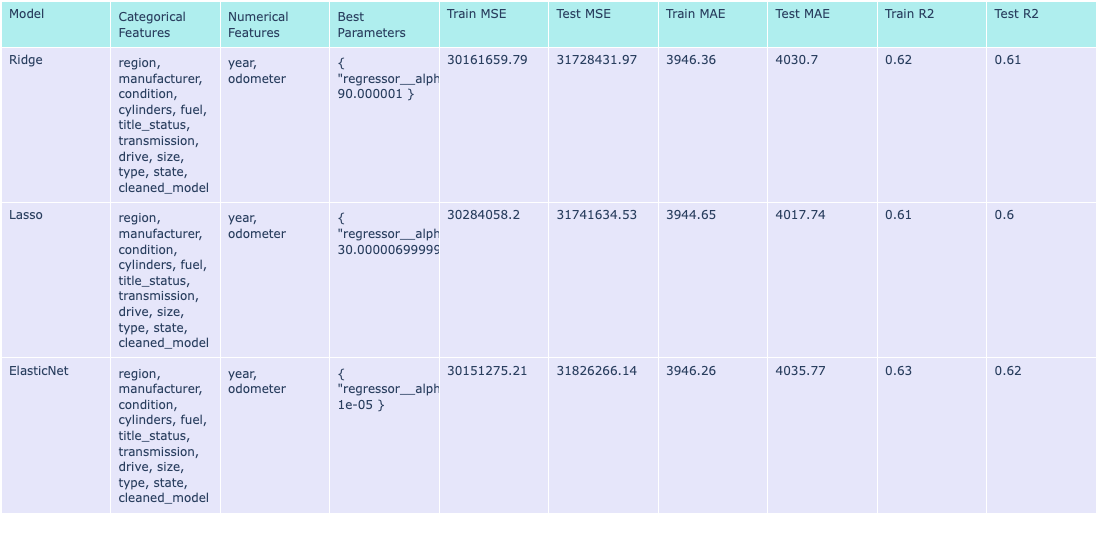

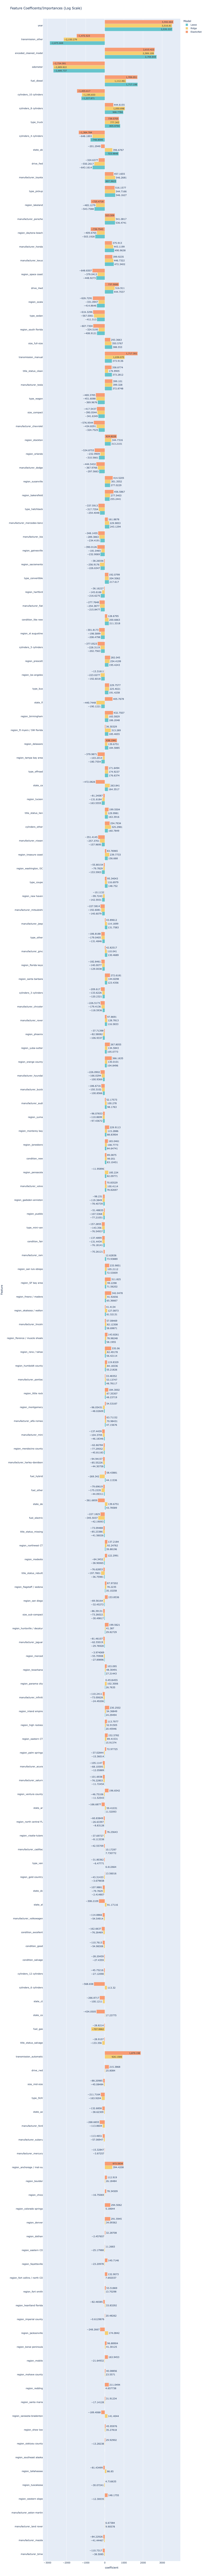

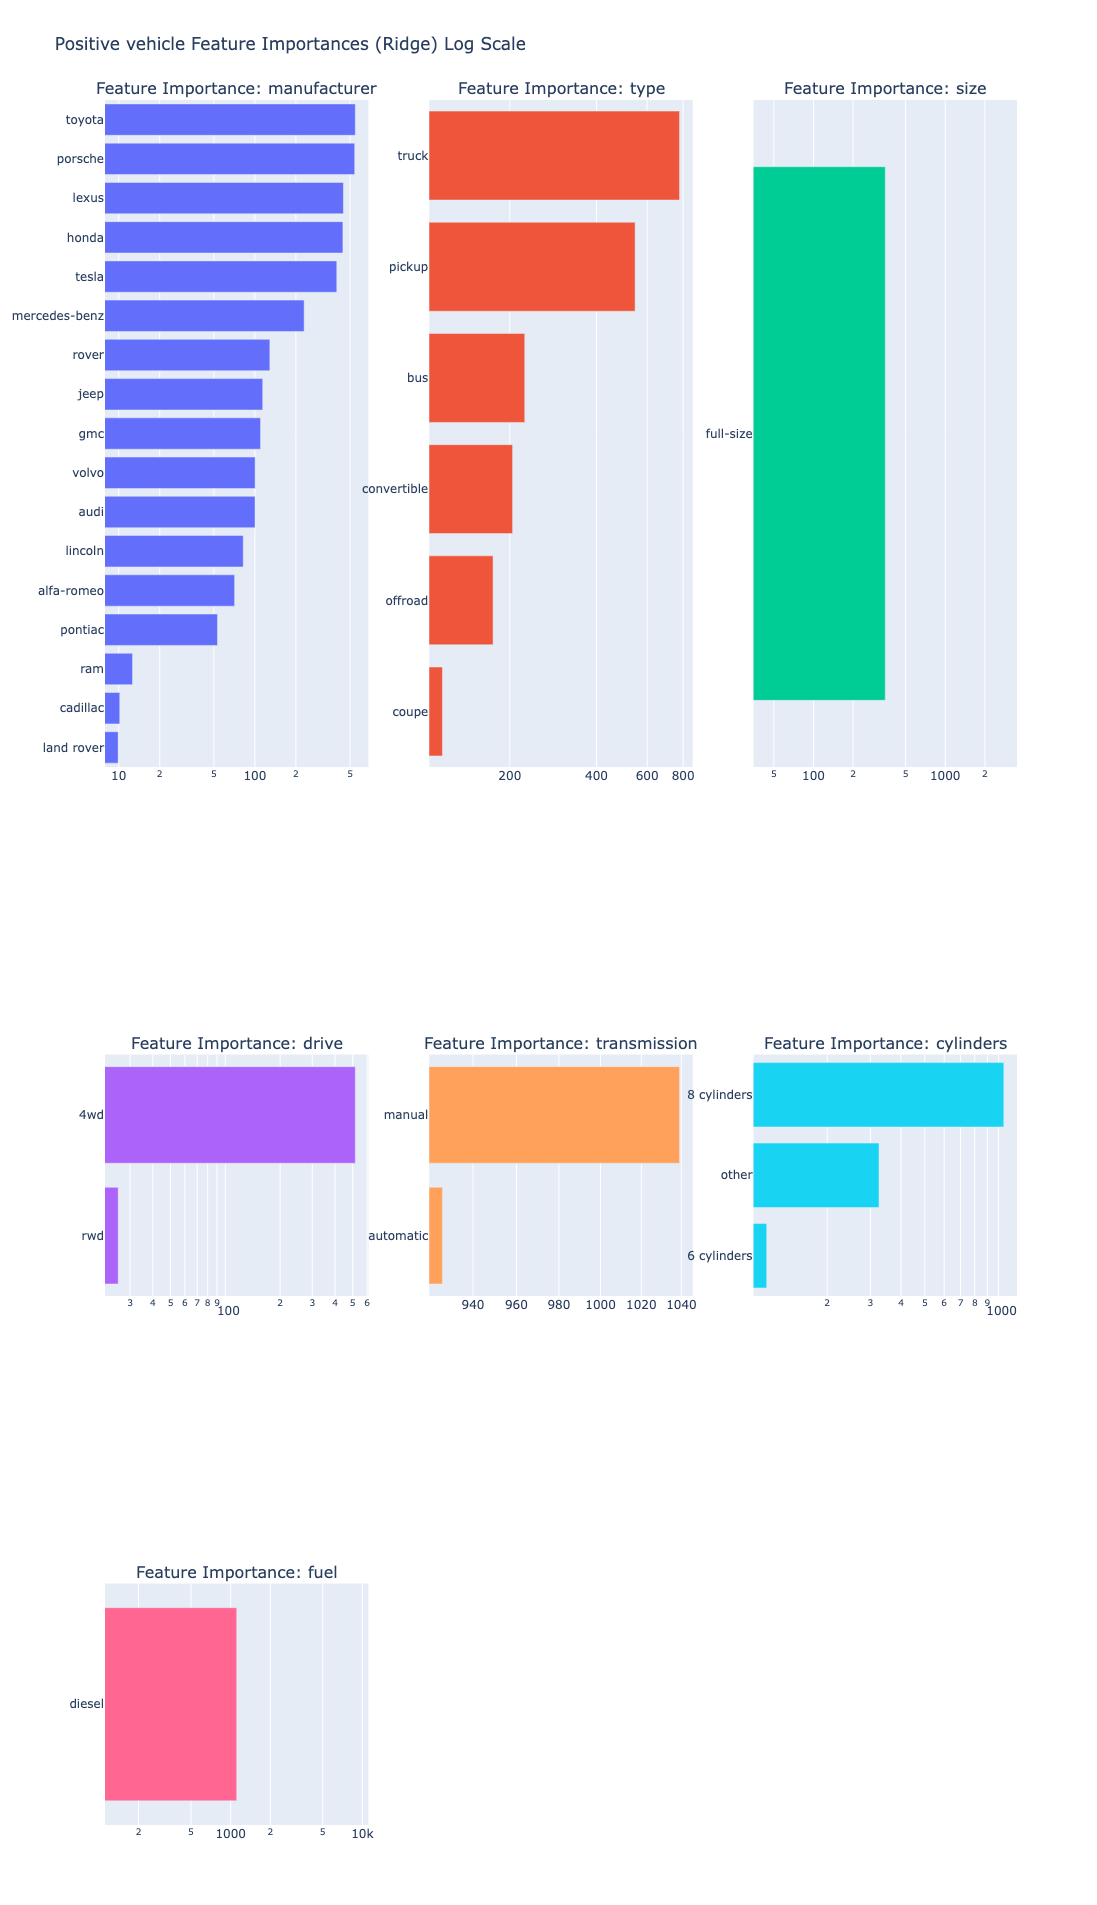

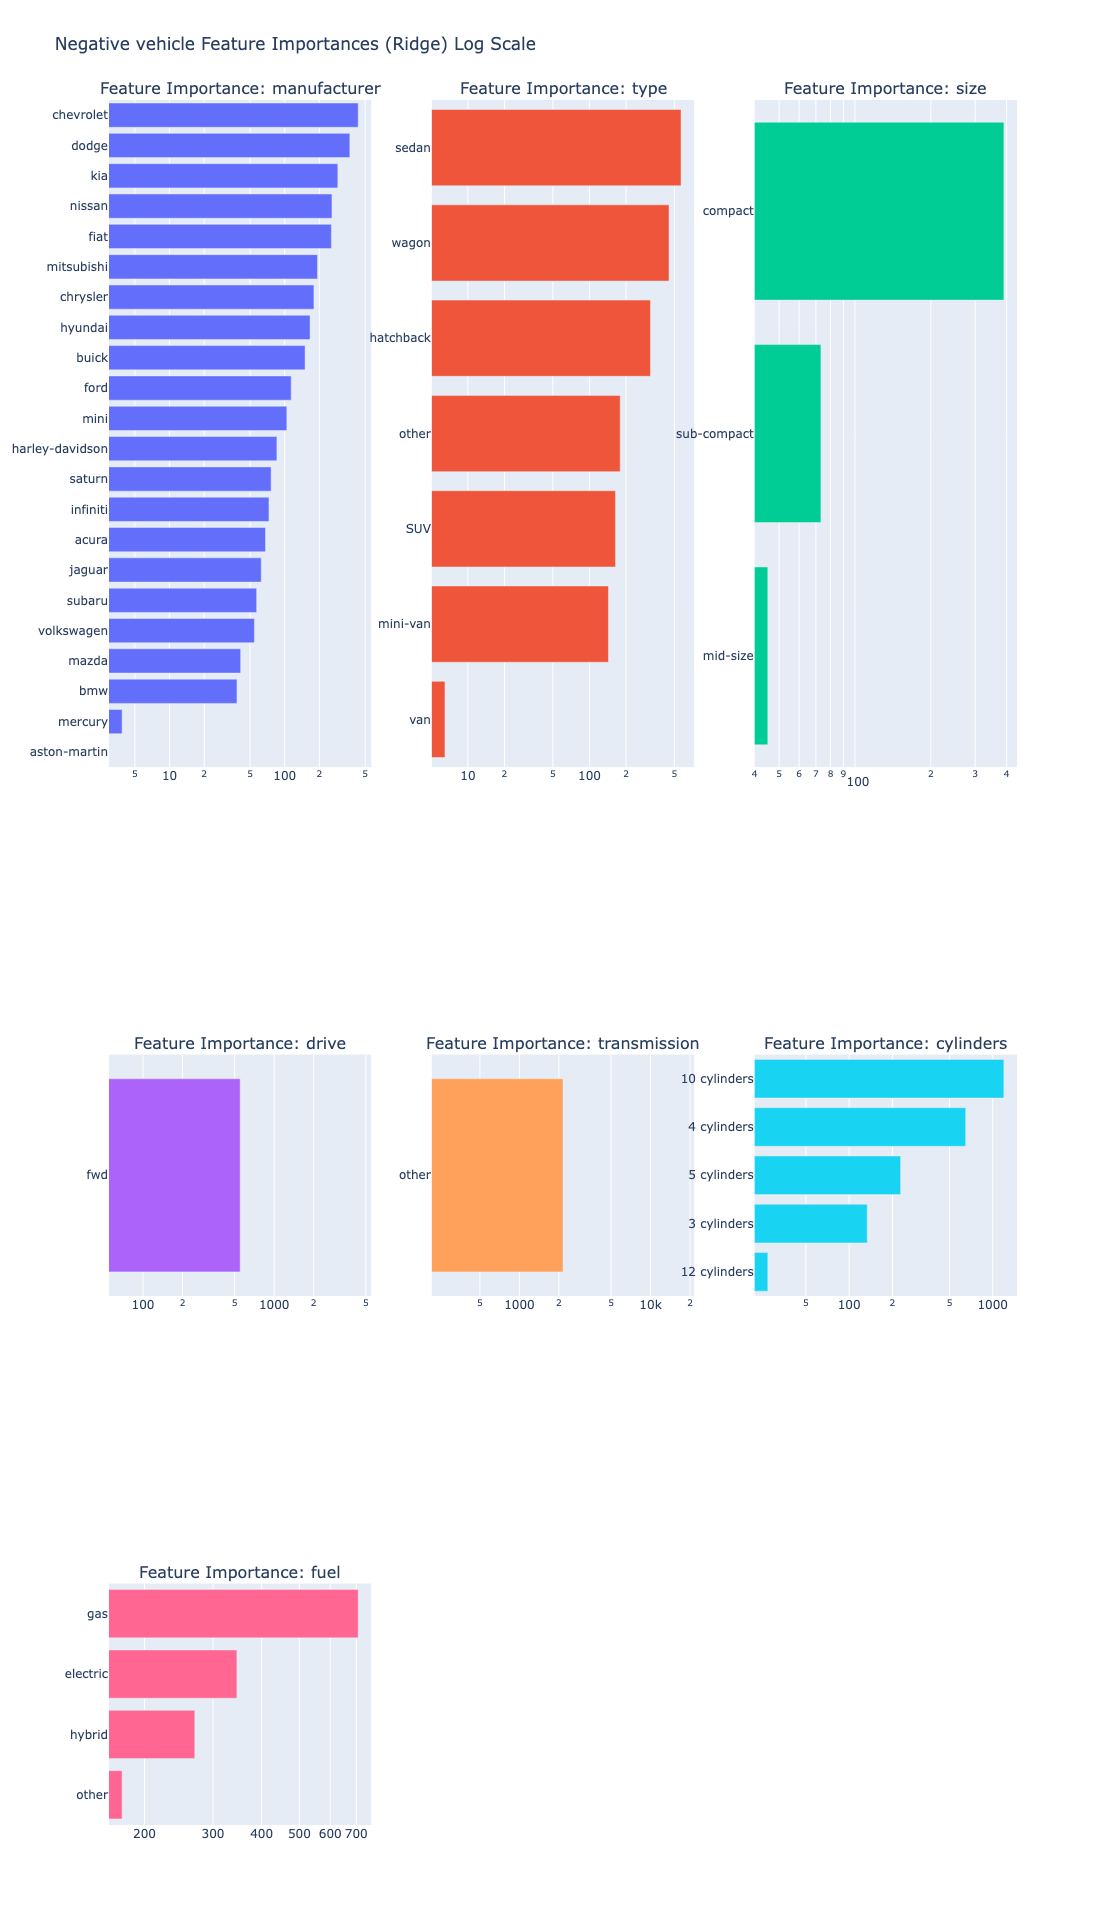

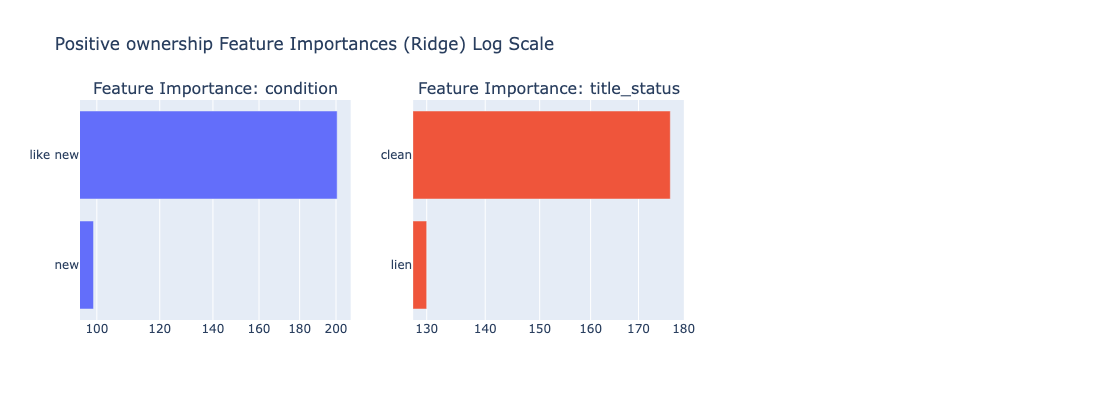

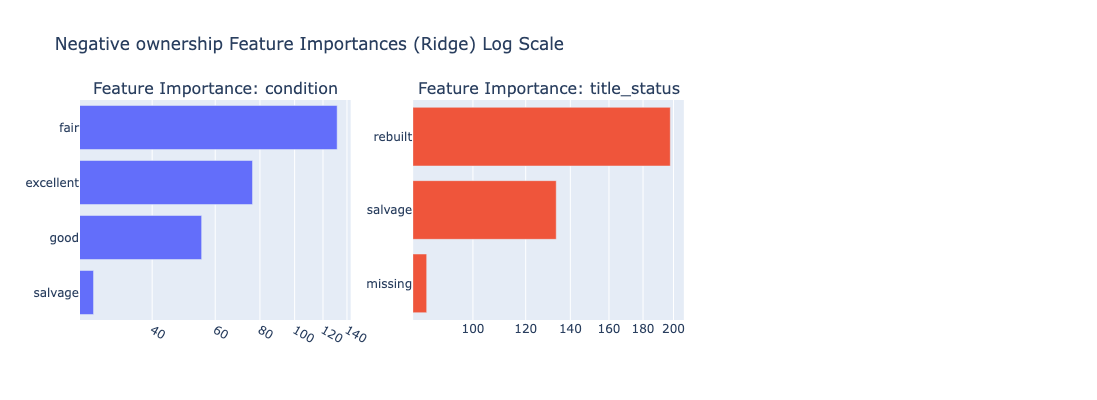

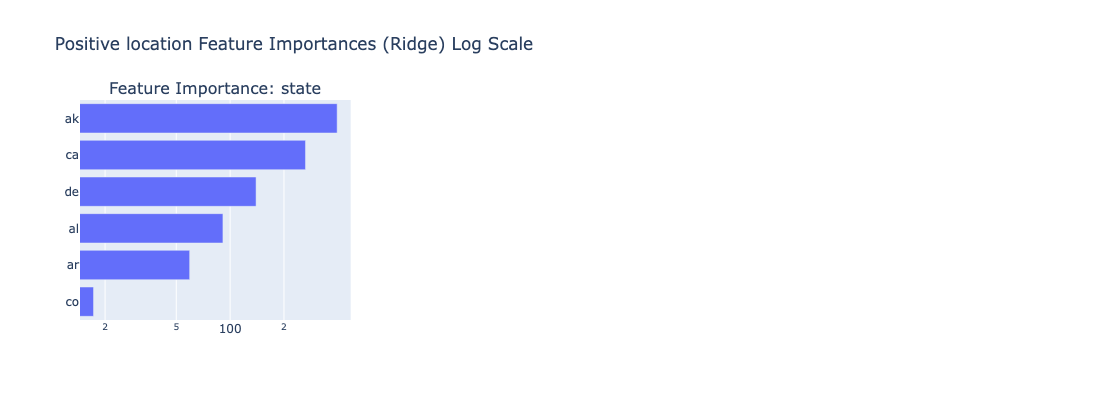

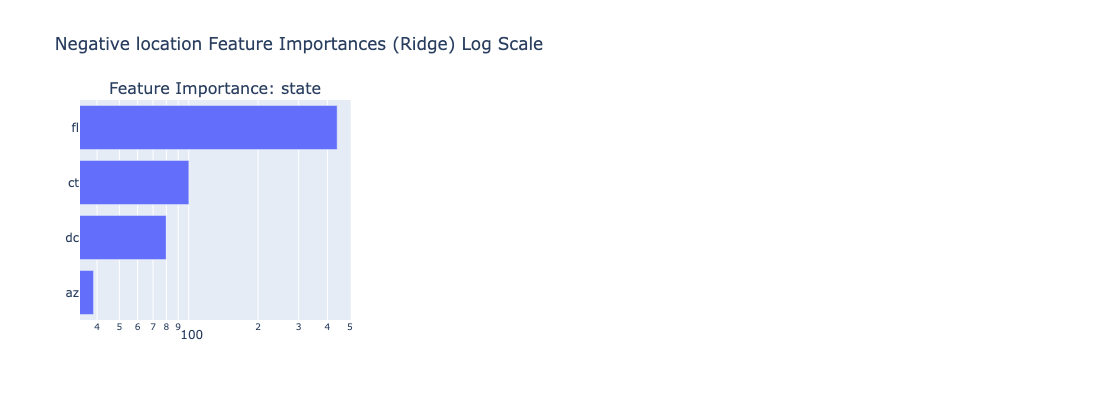

In [15]:
def graphFeatureCoefficients(modelPerformanceReportDf, featureCoefficientReportDf, categoryFeatureSets):

    modelPerfDf = modelPerformanceReportDf.sort_values('Test MSE', ascending=True)
    bestPerformer = modelPerfDf.iloc[0]['Model']
    dataFrame2Image(modelPerfDf, IMAGE_PREFIX + 'performance.png', height_per_row=10)
    
    colorPalette=px.colors.qualitative.Pastel

    # All coefficients across all models
    featureImportanceDf = featureCoefficientReportDf.copy()
    width = 1200
    height = len(featureCoefficientReportDf) * 25
    featureImportanceDf['coefficient_abs'] = featureImportanceDf['coefficient'].abs()
    featureImportanceDf = featureImportanceDf.sort_values('coefficient_abs', ascending=True)
    fig = px.bar(featureImportanceDf, title='Feature Coefficents/Importances (Log Scale)', y='index', x='coefficient', color='Model', text_auto=True, barmode="group", orientation='h', 
                color_discrete_sequence=colorPalette, width=width, height=height, labels={'index': 'Feature' }, text_auto=True)
    #fig.update_traces(marker_color='red')
    #fig.update_xaxes(type="log") # Can't do log as doesn't work with negative values
    fig.show()
    pio.write_image(fig, IMAGE_PREFIX + 'coefficient.png');

    
    bestModelFeatureImportanceDf = featureImportanceDf.loc[featureImportanceDf['Model'] == bestPerformer]
    subPlotCols = 3
    subPlotHeightPerRow = 65
    subPlotBaseHeight = 400
    subPlotBaseWidth = 800
    subPlotTotalWidth = subPlotBaseWidth * subPlotCols
    for key, value in categoryFeatureSets.items():
        features = value
        subPlotRows = math.ceil(len(features) / subPlotCols)
        
        subPlotRow = 1
        subPlotCol = 1
        structure = {
            'pos': {},
            'neg': {}
        }
        subPlotTitles = []
        for f in features:
            subPlotTitles.append('Feature Importance: ' + f)
            featureDf = bestModelFeatureImportanceDf.loc[bestModelFeatureImportanceDf['index'].str.startswith(f)]
            posDf = featureDf.loc[featureDf['coefficient'] > 0]
            negDf = featureDf.loc[featureDf['coefficient'] <= 0]

            posNode = structure['pos']
            negNode = structure['neg']
            k = subPlotRow
            if k not in posNode:
                posNode[k] = { 'maxRows': 0 }
                negNode[k] = { 'maxRows': 0 }
            
            posNode[k]['maxRows'] = max(len(posDf),posNode[k]['maxRows'])
            negNode[k]['maxRows'] = max(len(negDf),posNode[k]['maxRows'])
            
            subPlotCol +=1
            if subPlotCol % (subPlotCols + 1) == 0:
                subPlotRow += 1
                subPlotCol = 1

        #print(structure)

        posHeightTotal = 0
        posHeights = []
        for k, v in structure['pos'].items():
            currHeight = max(v['maxRows'] * subPlotHeightPerRow, subPlotBaseHeight)
            posHeightTotal += currHeight
            posHeights.append(currHeight)

        negHeightTotal = 0
        negHeights = []
        for k, v in structure['neg'].items():
            currHeight = max(v['maxRows'] * subPlotHeightPerRow, subPlotBaseHeight)
            negHeightTotal += currHeight
            negHeights.append(currHeight)

        posFig = make_subplots(rows=subPlotRows, cols=subPlotCols, row_heights=posHeights, subplot_titles=subPlotTitles)
        negFig = make_subplots(rows=subPlotRows, cols=subPlotCols, row_heights=negHeights, subplot_titles=subPlotTitles)

        subPlotRow = 1
        subPlotCol = 1
        for f in features:
            featureDf = bestModelFeatureImportanceDf.loc[bestModelFeatureImportanceDf['index'].str.startswith(f)]
            posDf = featureDf.loc[featureDf['coefficient'] > 0]
            negDf = featureDf.loc[featureDf['coefficient'] <= 0]
            posFig.add_trace(go.Bar(y=posDf['index'].str.replace(f + '_', ''), x=posDf['coefficient_abs'], orientation='h'), text_auto=True, row=subPlotRow, col=subPlotCol)
            negFig.add_trace(go.Bar(y=negDf['index'].str.replace(f + '_', ''), x=negDf['coefficient_abs'], orientation='h'), text_auto=True, row=subPlotRow, col=subPlotCol)
            subPlotCol +=1
            if subPlotCol % (subPlotCols + 1) == 0:
                subPlotRow += 1
                subPlotCol = 1

        posHeightTotal = max(posHeightTotal, subPlotBaseHeight)
        negHeightTotal = max(negHeightTotal, subPlotBaseHeight)
        
        posFig.update_xaxes(type="log")
        posFig.update_layout(height=posHeightTotal, width=subPlotTotalWidth, title_text='Positive ' + key + ' Feature Importances (' + bestPerformer + ') Log Scale', showlegend=False)
        posFig.show()
        
        negFig.update_xaxes(type="log")
        negFig.update_layout(height=negHeightTotal, width=subPlotTotalWidth, title_text='Negative ' + key + ' Feature Importances (' + bestPerformer + ') Log Scale', showlegend=False)
        #negFig.update_traces(marker_color='red')
        negFig.show()

        scale = 1
        
        pio.write_image(posFig, IMAGE_PREFIX + key + '.feature_importance.positive.png', scale=scale, width=subPlotTotalWidth, height=posHeightTotal)
        pio.write_image(negFig, IMAGE_PREFIX + key + '.feature_importance.negative.png', scale=scale, width=subPlotTotalWidth, height=negHeightTotal)
    
featureSets = {
    'vehicle': ['manufacturer','type', 'size', 'drive', 'transmission', 'cylinders', 'fuel'],
    'ownership': ['condition', 'title_status'],
    'location': ['state']
}
graphFeatureCoefficients(modelReportDf, featureImportanceReportDf, featureSets)

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.